In [1]:
import torch
import numpy as np
import pandas as pd
import category_encoders as ce
from tqdm import notebook
import matplotlib.pyplot as plt
import gc
import pickle as pkl
import shutil
from tqdm import tqdm, notebook
import glob
import os
from scipy import stats
pd.options.mode.chained_assignment = None

In [2]:
import sys

sys.path.extend(['..'])
from data_loader.data_generator import DataLoader
from utils.data_utils import *
from utils.training_utils import ModelCheckpoint, EarlyStopping
from losses_and_metrics import loss_functions, metrics
from config import Config

seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
np.random.seed(seed)

#### Prepare data

In [3]:
def read_data(input_data_dir='../../data/'):
    input_data_dir='../../data/'
    train_data = pd.read_csv(f'{input_data_dir}/sales_train_validation.csv')
    sell_prices = pd.read_csv(f'{input_data_dir}/sell_prices.csv')
    calendar = pd.read_csv(f'{input_data_dir}/calendar.csv')

    # ---- process calendar features ---- #
    print('* Processing calendar features')

    calendar.date = pd.to_datetime(calendar.date)
    calendar['relative_year'] = 2016 - calendar.year

    # convert month, day and weekday to cyclic encodings
    calendar['month_sin'] = np.sin(2 * np.pi * calendar.month/12.0)
    calendar['month_cos'] = np.cos(2 * np.pi * calendar.month/12.0)
    calendar['day_sin'] = np.sin(2 * np.pi * calendar.date.dt.day/calendar.date.dt.days_in_month)
    calendar['day_cos'] = np.cos(2 * np.pi * calendar.date.dt.day/calendar.date.dt.days_in_month)
    calendar['weekday_sin'] = np.sin(2 * np.pi * calendar.wday/7.0)
    calendar['weekday_cos'] = np.cos(2 * np.pi * calendar.wday/7.0)

    calendar_df = calendar[['wm_yr_wk', 'd', 'snap_CA', 'snap_TX', 'snap_WI', 'relative_year',
                            'month_sin', 'month_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos']]

    # ---- Merge all dfs, keep calender_df features separate and just concat them for each batch ---- #
    train_data.id = train_data.id.str[:-11]
    sell_prices['id'] = sell_prices['item_id'] + '_' + sell_prices['store_id']

    # add empty columns for future data
    train_data = pd.concat([train_data, pd.DataFrame(columns=['d_'+str(i) for i in range(1914, 1970)])])

    # Reshape, change dtypes and add previous day sales
    print('* Add previous day sales and merge sell prices')
    data_df = pd.melt(train_data, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                      var_name='d', value_vars=['d_'+str(i) for i in range(1, 1970)], value_name='sales')

    # change dtypes to reduce memory usage
    data_df[['sales']] = data_df[['sales']].fillna(-2).astype(np.int16)  # fill future sales as -2
    calendar_df[['snap_CA', 'snap_TX', 'snap_WI', 'relative_year']] = calendar_df[
        ['snap_CA', 'snap_TX', 'snap_WI', 'relative_year']].astype(np.int8)

    # merge sell prices
    data_df = data_df.merge(right=calendar_df[['d', 'wm_yr_wk']], on=['d'], how='left')
    data_df = data_df.merge(right=sell_prices[['id', 'wm_yr_wk', 'sell_price']], on=['id', 'wm_yr_wk'], how='left')

    data_df.sell_price = data_df.sell_price.fillna(0.0)

    # remove data for d_1
    data_df = data_df[data_df.d != 'd_1']
    calendar_df = calendar_df[calendar_df.d != 'd_1']

    # remove category columns
    del data_df['wm_yr_wk']
    del data_df['item_id']
    del data_df['dept_id']
    del data_df['cat_id']
    del data_df['store_id']
    del data_df['state_id']

    num_samples = data_df.id.nunique()
    num_timesteps = data_df.d.nunique()
    data_df = data_df.set_index(['id', 'd'])

    ids = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    enc_dec_feats = ['sell_price']
    enc_only_feats = data_df.columns.difference(['sales', 'sell_price', 'prev_day_sales'] + enc_dec_feats)

    sales_data_ids = train_data[ids].values
    Y_l12 = data_df.sales.values.reshape(num_timesteps, num_samples).T
    X_enc_dec_feats = np.array(data_df[enc_dec_feats]).reshape(num_timesteps, num_samples, -1)
    calendar_index = calendar_df.d
    X_calendar = np.array(calendar_df.iloc[:, 2:])
    X_calendar_cols = list(calendar_df.columns[2:])

    sell_price_i = enc_dec_feats.index('sell_price')

    sell_price_l12 = X_enc_dec_feats[:, :, sell_price_i]
    sell_price_all, _, _ = get_aggregated_series(X_enc_dec_feats[:, :, sell_price_i].T, sales_data_ids, 'mean')

    Y, agg_ids, _ = get_aggregated_series(Y_l12, sales_data_ids)

    X = np.stack([Y, sell_price_all], axis=1)

    data_dict = {'sales_data_ids': sales_data_ids, 'agg_ids': agg_ids, 'calendar_index': calendar_index,
                 'X_enc_dec_feats' : X_enc_dec_feats, 'enc_dec_feat_names': enc_dec_feats,
                 'X_calendar': X_calendar, 'X_calendar_cols': X_calendar_cols,
                 'X': X}
    return data_dict

In [4]:
data_dict = read_data()

* Processing calendar features
* Add previous day sales and merge sell prices


#### Prepare graph data

In [5]:
agg_ids = data_dict['agg_ids']
ids = data_dict['sales_data_ids']
X_calendar = data_dict['X_calendar']
X = data_dict['X']

In [6]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# create graph and get adjacency matrix
G = nx.DiGraph()
G.add_edges_from([('Level1_Total_X', 'Level2_CA_X'), 
                  ('Level1_Total_X', 'Level2_TX_X'), 
                  ('Level1_Total_X', 'Level2_WI_X')])

ids_df = pd.DataFrame(ids, columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])

ids_df['store_cat_id'] = ids_df['store_id'] + '_' + ids_df['cat_id']
ids_df['store_dept_id'] = ids_df['store_id'] + '_' + ids_df['dept_id']
ids_df['item_store_id'] = ids_df['item_id'] + '_' + ids_df['store_id']
ids_df['state_cat_id'] = ids_df['state_id'] + '_' + ids_df['cat_id']
ids_df['state_dept_id'] = ids_df['state_id'] + '_' + ids_df['dept_id']
ids_df['state_item_id'] = ids_df['state_id'] + '_' + ids_df['item_id']

ids_df['state_id'] = 'Level2_' + ids_df['state_id'] + '_X'
ids_df['store_id'] = 'Level3_' + ids_df['store_id'] + '_X'
ids_df['cat_id'] = 'Level4_' + ids_df['cat_id'] + '_X'
ids_df['dept_id'] = 'Level5_' + ids_df['dept_id'] + '_X'
ids_df['state_cat_id'] = 'Level6_' + ids_df['state_cat_id']
ids_df['state_dept_id'] = 'Level7_' + ids_df['state_dept_id']
ids_df['store_cat_id'] = 'Level8_' + ids_df['store_cat_id']
ids_df['store_dept_id'] = 'Level9_' + ids_df['store_dept_id']
ids_df['item_id'] = 'Level10_' + ids_df['item_id'] + '_X'
ids_df['state_item_id'] = 'Level11_' + ids_df['state_item_id']
ids_df['item_store_id'] = 'Level12_' + ids_df['item_store_id']

G.add_edges_from(list(ids_df.groupby(['state_id', 'store_id']).groups.keys()))
G.add_edges_from(list(ids_df.groupby(['store_id', 'store_cat_id']).groups.keys()))
G.add_edges_from(list(ids_df.groupby(['store_cat_id', 'store_dept_id']).groups.keys()))
G.add_edges_from(list(ids_df.groupby(['store_dept_id', 'item_store_id']).groups.keys()))

G.add_edges_from(list(ids_df.groupby(['store_cat_id', 'cat_id']).groups.keys()))
G.add_edges_from(list(ids_df.groupby(['store_dept_id', 'dept_id']).groups.keys()))
G.add_edges_from(list(ids_df.groupby(['store_cat_id', 'state_cat_id']).groups.keys()))
G.add_edges_from(list(ids_df.groupby(['store_dept_id', 'state_dept_id']).groups.keys()))
G.add_edges_from(list(ids_df.groupby(['item_store_id', 'item_id']).groups.keys()))
G.add_edges_from(list(ids_df.groupby(['item_store_id', 'state_item_id']).groups.keys()))

In [7]:
G.number_of_edges(), G.number_of_nodes()

(91783, 42840)

In [8]:
colors = ['black', 'red', 'blue', 'green', 'yellow', 'pink', 'orange', 'cyan', 'indigo', 'brown', 'gray', 'white']
color_map_G = {}
color_map_G['Level1_Total_X'] = colors[0]  # Level 1
l1 = ['Level1_Total_X']
l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12 = [], [], [], [], [], [], [], [], [], [], []
for n in ids_df['state_id'].unique():  # Level 2
    l2.append(n)
    color_map_G[n] = colors[1]
for n in ids_df['store_id'].unique():  # Level 3
    l3.append(n)
    color_map_G[n] = colors[2]
for n in ids_df['cat_id'].unique():  # Level 4
    l4.append(n)
    color_map_G[n] = colors[3]
for n in ids_df['dept_id'].unique():  # Level 5
    l5.append(n)
    color_map_G[n] = colors[4]
for n in ids_df['state_cat_id'].unique():  # Level 6
    l6.append(n)
    color_map_G[n] = colors[5]
for n in ids_df['state_dept_id'].unique():  # Level 7
    l7.append(n)
    color_map_G[n] = colors[6]
for n in ids_df['store_cat_id'].unique():  # Level 8
    l8.append(n)
    color_map_G[n] = colors[7]
for n in ids_df['store_dept_id'].unique():  # Level 9
    l9.append(n)
    color_map_G[n] = colors[8]
for n in ids_df['item_id'].unique():  # Level 10
    l10.append(n)
    color_map_G[n] = colors[9]
for n in ids_df['state_item_id'].unique():  # Level 11
    l11.append(n)
    color_map_G[n] = colors[10]
for n in ids_df['item_store_id'].unique():  # Level 12
    l12.append(n)
    color_map_G[n] = colors[11]

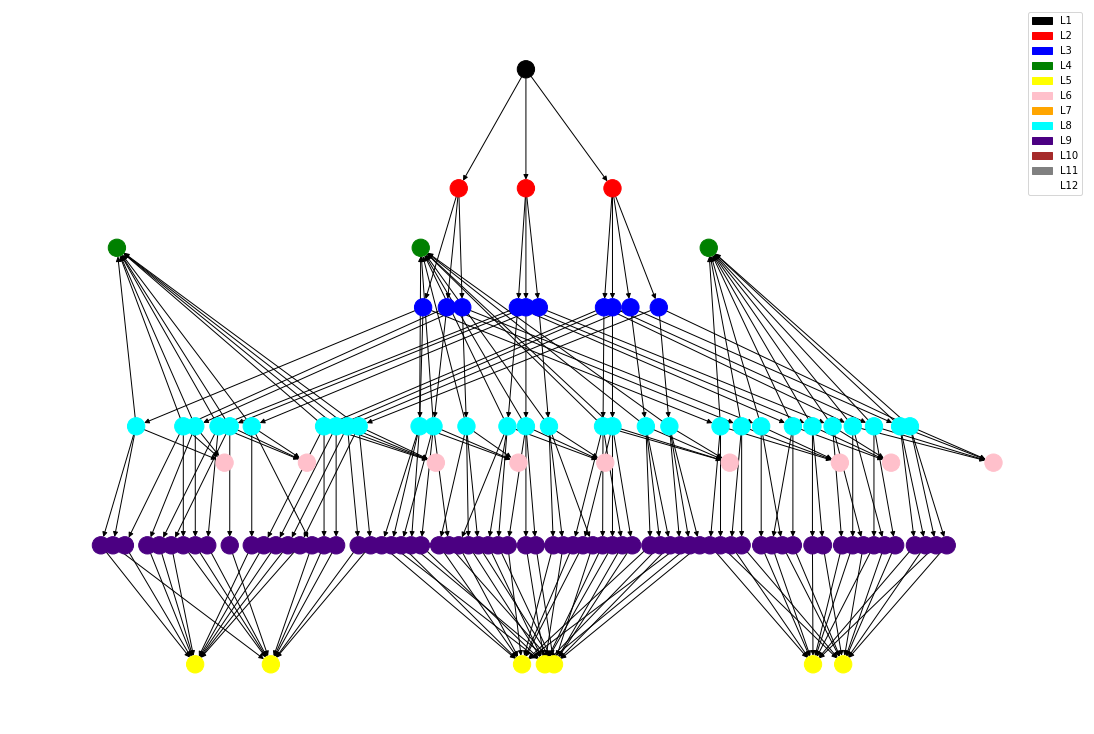

In [9]:
subgraph_G = G.subgraph(l1 + l2 + l3 + l4 + l5 + l6 + l8 + l9)

color_map_G_lst = []
for node in list(subgraph_G.nodes()):
    if node in color_map_G.keys():
        color_map_G_lst.append(color_map_G[node])
    else:
        color_map_G_lst.append('blue')
        
write_dot(subgraph_G,'test.dot')

# same layout using matplotlib with no labels
plt.figure(figsize=(15, 10))
pos = graphviz_layout(subgraph_G, prog='dot')

for k, v in pos.items():
    if k in l4:
        pos[k] = (v[0] - 2800, v[1] + 180)
    if k in l6:
        pos[k] = (v[0] + 2000, v[1] + 50)
nx.draw(subgraph_G, pos, with_labels=False, arrows=True, node_color=color_map_G_lst)

patches = [mpatches.Patch(color=colors[i], label=f'L{i + 1}') for i in range(12)]
plt.legend(handles=patches)
plt.show()

In [18]:
def get_normalized_adj_matrix(G, nodelist):
    A = nx.to_numpy_array(G, nodelist=nodelist).astype(np.int8)

    A = A + np.diag(np.ones(A.shape[0], dtype=np.int8))
    D = np.array(np.sum(A, axis=1)).reshape((-1,))
    D[D <= 10e-5] = 10e-5    # Prevent infs
    diag = np.reciprocal(np.sqrt(D)).astype(np.float32)
    A_wave = np.multiply(np.multiply(diag.reshape((-1, 1)), A),
                         diag.reshape((1, -1))).astype(np.float32)
    
    return A_wave

In [19]:
A_wave = get_normalized_adj_matrix(G, agg_ids)

#### Create torch dataset

In [30]:
ids_idx_dict = {k: v for k,v in zip(agg_ids, range(len(agg_ids)))}

In [34]:
edge_data = np.array([(ids_idx_dict[i[0]], ids_idx_dict[i[1]]) for i in list(G.edges)])

In [37]:
edge_data

array([[    0,     1],
       [    0,     2],
       [    0,     3],
       ...,
       [41401, 12348],
       [41402,  3202],
       [41402, 12349]])

In [38]:
np.savetxt(r'./deepwalk-c/m5_edge_list.txt', edge_data, fmt='%d')

In [39]:
embedding = np.fromfile('./deepwalk-c/m5.embeddings', np.float32).reshape(G.number_of_nodes(), 128)

In [42]:
embedding

array([[-0.02277552, -0.07473265, -0.1698443 , ...,  0.02752152,
         0.11318893, -0.07964224],
       [-0.01776486, -0.00813451,  0.1930415 , ...,  0.1545295 ,
         0.19373435,  0.01314174],
       [ 0.08185062, -0.12911528, -0.25587806, ...,  0.03476669,
         0.06344888, -0.06435016],
       ...,
       [ 0.05743155,  0.06536444,  0.02203737, ...,  0.0423669 ,
         0.26875573, -0.30895117],
       [ 0.07659578,  0.08989731,  0.13105032, ..., -0.22311021,
        -0.28233704,  0.15382127],
       [ 0.05007093, -0.30218148, -0.13455884, ..., -0.01333986,
         0.18457453, -0.1725427 ]], dtype=float32)

In [40]:
embedding

array([[-0.02277552, -0.07473265, -0.1698443 , ...,  0.02752152,
         0.11318893, -0.07964224],
       [-0.01776486, -0.00813451,  0.1930415 , ...,  0.1545295 ,
         0.19373435,  0.01314174],
       [ 0.08185062, -0.12911528, -0.25587806, ...,  0.03476669,
         0.06344888, -0.06435016],
       ...,
       [ 0.05743155,  0.06536444,  0.02203737, ...,  0.0423669 ,
         0.26875573, -0.30895117],
       [ 0.07659578,  0.08989731,  0.13105032, ..., -0.22311021,
        -0.28233704,  0.15382127],
       [ 0.05007093, -0.30218148, -0.13455884, ..., -0.01333986,
         0.18457453, -0.1725427 ]], dtype=float32)

#### Data Generator

In [ ]:
# Dataset (Input Pipeline)
class CustomDataset(data_utils.Dataset):
    """
    Custom dataset

    Let:
    training period timesteps = [0, N]
    prediction period timesteps = [N+1, N+P]

    Arguments:
    X : sales for training period ([0, N])
    X_calendar : calendar features for training and prediction period ([0, N])
    Y : actual sales, denoting targets for prediction period ([N+1, N+P]) (only in training phase)
    A : normalized adjacency matrix
    mode : choose one of ['train', 'val', 'test']

    Returns:
    List of torch arrays:
    x : concatenated features
    A : normalized adjacency matrix
    norm_factor : normalization factor for target (Y)
    y : targets (only in training phase)
    wrmsse_weights : weights for spl/wrmsse calc (only in training phase)
    rmsse_denominator : scaling factor for spl/wrmsse calc (only in training phase)
    """

    def __init__(self, X, X_calendar, A, config, mode=None):

        self.X = X
        self.X_calendar = X_calendar
        self.A = A
        self.config = config
        self.mode = mode
        
        self.num_input_ts = self.
        
        if Y is not None:
            self.Y = torch.from_numpy(Y).float()
            self.rmsse_denominator = torch.from_numpy(rmsse_denominator).float()
            self.wrmsse_weights = torch.from_numpy(wrmsse_weights).float()
        else:
            self.Y = None

    def __len__(self):
        return self.X.shape[2] - (self.config.window_length + 28) + 1 if mode == 'train' \
                else self.X.shape[2] - (2 * (self.config.window_length + 28)) + 1

    def __getitem__(self, idx):
        if self.window_id is not None:
            X_calendar = self.X_calendar[self.window_id[idx]]
            scale = self.rmsse_denominator[idx - (self.window_id[idx] * 42840)]
            weight = self.wrmsse_weights[idx - (self.window_id[idx] * 42840)]
            ids_idx = idx - (self.window_id[idx] * 42840)
            window_id = self.window_id[idx]
        else:
            X_calendar = self.X_calendar
            if self.Y is not None:
                scale = self.rmsse_denominator[idx]
                weight = self.wrmsse_weights[idx]
                ids_idx = idx
                window_id = 0

        enc_timesteps = self.X_prev_day_sales.shape[0]
        dec_timesteps = self.X_enc_dec_feats.shape[0] - enc_timesteps
        num_embedding = 5
        num_cal_embedding = 2

        # input data for encoder
        x_enc_dec_feats_enc = self.X_enc_dec_feats[:enc_timesteps, idx, :-num_embedding].reshape(enc_timesteps, -1)
        # x_enc_only_feats = self.X_enc_only_feats[:, idx, :].reshape(enc_timesteps, -1)
        x_prev_day_sales_enc = self.X_prev_day_sales[:, idx].reshape(-1, 1)
        x_calendar_enc = X_calendar[:enc_timesteps, :-num_cal_embedding]
        x_calendar_enc_emb = X_calendar[:enc_timesteps, -num_cal_embedding:].reshape(enc_timesteps, -1)
        # x_enc = np.concatenate([x_enc_dec_feats_enc, x_calendar_enc,
        #                         x_prev_day_sales_enc, x_enc_only_feats], axis=1)
        x_enc = np.concatenate([x_enc_dec_feats_enc, x_calendar_enc, x_prev_day_sales_enc], axis=1)
        x_enc_emb = self.X_enc_dec_feats[:enc_timesteps, idx, -num_embedding:].reshape(enc_timesteps, -1)

        # input data for decoder
        x_enc_dec_feats_dec = self.X_enc_dec_feats[enc_timesteps:, idx, :-num_embedding].reshape(dec_timesteps, -1)
        x_calendar_dec = X_calendar[enc_timesteps:, :-num_cal_embedding]
        x_calendar_dec_emb = X_calendar[enc_timesteps:, -num_cal_embedding:].reshape(dec_timesteps, -1)
        x_prev_day_sales_dec = self.X_prev_day_sales_dec[:, idx].reshape(-1, 1)
        x_dec = np.concatenate([x_enc_dec_feats_dec, x_calendar_dec], axis=1)
        x_dec_emb = self.X_enc_dec_feats[enc_timesteps:, idx, -num_embedding:].reshape(dec_timesteps, -1)

        if self.Y is None:
            return [[torch.from_numpy(x_enc).float(), torch.from_numpy(x_enc_emb).long(),
                     torch.from_numpy(x_calendar_enc_emb).long(),
                     torch.from_numpy(x_dec).float(), torch.from_numpy(x_dec_emb).long(),
                     torch.from_numpy(x_calendar_dec_emb).long(),
                     torch.from_numpy(x_prev_day_sales_dec).float()], self.norm_factor[idx]]

        return [[torch.from_numpy(x_enc).float(), torch.from_numpy(x_enc_emb).long(),
                 torch.from_numpy(x_calendar_enc_emb).long(),
                 torch.from_numpy(x_dec).float(), torch.from_numpy(x_dec_emb).long(),
                 torch.from_numpy(x_calendar_dec_emb).long(),
                 torch.from_numpy(x_prev_day_sales_dec).float()],
                self.Y[idx, :], torch.from_numpy(np.array(self.norm_factor[idx])).float(),
                ids_idx,
                [scale, weight],
                window_id]


class DataLoader:
    def __init__(self, config, X, X_calendar, agg_ids, A):
        self.config = config

        self.ids = agg_ids
        self.X = X
        self.X_calendar = X_calendar
        self.A = A

    def create_train_loader(self, data_start_t=None, horizon_start_t=None, horizon_end_t=None):
        if (data_start_t is None) | (horizon_start_t is None) | (horizon_end_t is None):
            data_start_t = self.config.training_ts['data_start_t']
            horizon_start_t = self.config.training_ts['horizon_start_t']
            horizon_end_t = self.config.training_ts['horizon_end_t']

        # Run a sliding window of length "window_length" and train for the next month of each window
        window_length = self.config.window_length
        X_prev_day_sales, X_enc_only_feats, X_enc_dec_feats, X_calendar, Y, norm_factor = [], [], [], [], [], []
        X_prev_day_sales_dec, weights, scales = [], [], []

        for idx, i in enumerate(range(data_start_t + window_length, horizon_end_t, 28)):
            w_data_start_t, w_horizon_start_t = data_start_t + (idx * 28), i
            w_horizon_end_t = w_horizon_start_t + 28

            # calculate denominator for rmsse loss
            absolute_movement = np.absolute(self.Y.T[:w_horizon_start_t] -
                                            self.X_prev_day_sales[:w_horizon_start_t]).astype(np.int64)
            actively_sold_in_range = (self.X_prev_day_sales[:w_horizon_start_t] != 0).argmax(axis=0)
            rmsse_den = []
            for idx_active_sell, first_active_sell_idx in enumerate(actively_sold_in_range):
                den = absolute_movement[first_active_sell_idx:, idx_active_sell].mean()
                den = den if den != 0 else 1
                rmsse_den.append(den)
            scales.append(np.array(rmsse_den))

            # Get weights for WRMSSE and SPL loss
            w_weights, _ = get_weights_all_levels(self.Y_l12[:, w_horizon_start_t - 28:w_horizon_start_t],
                                                  self.sell_price_l12[w_horizon_start_t - 28:w_horizon_start_t, :].T,
                                                  self.ids)
            weights.append(w_weights)

            # Normalize sale features by dividing by median of each series (as per the selected input window)
            w_X_prev_day_sales = self.X_prev_day_sales[w_data_start_t:w_horizon_start_t].copy().astype(float)
            w_norm_factor = np.median(w_X_prev_day_sales, 0)
            w_norm_factor[w_norm_factor == 0] = 1.
            w_X_prev_day_sales = w_X_prev_day_sales / w_norm_factor
            w_X_prev_day_sales_dec = self.X_prev_day_sales[w_horizon_start_t:w_horizon_end_t]\
                                         .copy().astype(float) / w_norm_factor

            w_X_enc_dec_feats = self.X_enc_dec_feats[w_data_start_t:w_horizon_end_t]
            w_X_sell_p = self.X_enc_dec_feats[w_data_start_t:w_horizon_start_t, :, self.sell_price_i].copy().astype(float)
            w_norm_factor_sell_p = np.median(w_X_sell_p, 0)
            w_norm_factor_sell_p[w_norm_factor_sell_p == 0] = 1.
            w_X_enc_dec_feats[:, :, self.sell_price_i] = w_X_enc_dec_feats[:, :, self.sell_price_i] / w_norm_factor_sell_p

            X_prev_day_sales.append(w_X_prev_day_sales)
            X_enc_only_feats.append(self.X_enc_only_feats[w_data_start_t:w_horizon_start_t])
            X_enc_dec_feats.append(w_X_enc_dec_feats)
            X_calendar.append(self.X_calendar[w_data_start_t:w_horizon_end_t])
            X_prev_day_sales_dec.append(w_X_prev_day_sales_dec)
            norm_factor.append(w_norm_factor)
            Y.append(self.Y[:, w_horizon_start_t:w_horizon_end_t])

        self.n_windows = idx + 1
        X_prev_day_sales = np.concatenate(X_prev_day_sales, 1)
        X_enc_only_feats = np.concatenate(X_enc_only_feats, 1)
        X_enc_dec_feats = np.concatenate(X_enc_dec_feats, 1)
        X_calendar = np.stack(X_calendar, 0)
        X_prev_day_sales_dec = np.concatenate(X_prev_day_sales_dec, 1)
        Y = np.concatenate(Y, 0)
        scales = np.concatenate(scales, 0)
        weights = np.concatenate(weights, 0)
        norm_factor = np.concatenate(norm_factor, 0)
        window_id = np.arange(idx + 1).repeat(self.X_enc_dec_feats.shape[1])

        dataset = CustomDataset(X_prev_day_sales,
                                X_enc_only_feats,
                                X_enc_dec_feats,
                                X_calendar, X_prev_day_sales_dec,
                                norm_factor,
                                Y=Y,
                                rmsse_denominator=scales, wrmsse_weights=weights, window_id=window_id)

        return torch.utils.data.DataLoader(dataset=dataset, batch_size=self.config.batch_size, shuffle=True,
                                           num_workers=3, pin_memory=True)

    def create_val_loader(self, data_start_t=None, horizon_start_t=None, horizon_end_t=None):
        if (data_start_t is None) | (horizon_start_t is None) | (horizon_end_t is None):
            data_start_t = self.config.validation_ts['data_start_t']
            horizon_start_t = self.config.validation_ts['horizon_start_t']
            horizon_end_t = self.config.validation_ts['horizon_end_t']

        # calculate denominator for rmsse loss
        absolute_movement = np.absolute(self.Y.T[:horizon_start_t] -
                                        self.X_prev_day_sales[:horizon_start_t]).astype(np.int64)
        actively_sold_in_range = (self.X_prev_day_sales[:horizon_start_t] != 0).argmax(axis=0)
        rmsse_den = []
        for idx, first_active_sell_idx in enumerate(actively_sold_in_range):
            den = absolute_movement[first_active_sell_idx:, idx].mean()
            den = den if den != 0 else 1
            rmsse_den.append(den)

        # Get weights for WRMSSE and SPL loss
        weights, _ = get_weights_all_levels(self.Y_l12[:, horizon_start_t-28:horizon_start_t],
                                            self.sell_price_l12[horizon_start_t-28:horizon_start_t, :].T,
                                            self.ids)

        # Normalize sale features by dividing by median of each series (as per the selected input window)
        X_prev_day_sales = self.X_prev_day_sales[data_start_t:horizon_start_t].copy().astype(float)
        norm_factor = np.median(X_prev_day_sales, 0)
        norm_factor[norm_factor == 0] = 1.
        X_prev_day_sales = X_prev_day_sales / norm_factor
        X_prev_day_sales_dec = self.X_prev_day_sales[horizon_start_t:horizon_end_t] \
                                   .copy().astype(float) / norm_factor

        X_enc_dec_feats = self.X_enc_dec_feats[data_start_t:horizon_end_t]
        X_sell_p = self.X_enc_dec_feats[data_start_t:horizon_start_t, :, self.sell_price_i].copy().astype(float)
        norm_factor_sell_p = np.median(X_sell_p, 0)
        norm_factor_sell_p[norm_factor_sell_p == 0] = 1.
        X_enc_dec_feats[:, :, self.sell_price_i] = X_enc_dec_feats[:, :, self.sell_price_i] / norm_factor_sell_p

        dataset = CustomDataset(X_prev_day_sales,
                                self.X_enc_only_feats[data_start_t:horizon_start_t],
                                X_enc_dec_feats,
                                self.X_calendar[data_start_t:horizon_end_t], X_prev_day_sales_dec,
                                norm_factor,
                                Y=self.Y[:, horizon_start_t:horizon_end_t],
                                rmsse_denominator=np.array(rmsse_den), wrmsse_weights=weights)

        return torch.utils.data.DataLoader(dataset=dataset, batch_size=self.config.batch_size, num_workers=3,
                                           pin_memory=True)

    def create_test_loader(self, data_start_t=None, horizon_start_t=None, horizon_end_t=None):
        if (data_start_t is None) | (horizon_start_t is None) | (horizon_end_t is None):
            data_start_t = self.config.test_ts['data_start_t']
            horizon_start_t = self.config.test_ts['horizon_start_t']
            horizon_end_t = self.config.test_ts['horizon_end_t']

        # Normalize sale features by dividing by median of each series (as per the selected input window)
        X_prev_day_sales = self.X_prev_day_sales[data_start_t:horizon_start_t].copy().astype(float)
        norm_factor = np.median(X_prev_day_sales, 0)
        norm_factor[norm_factor == 0] = 1.
        X_prev_day_sales = X_prev_day_sales / norm_factor
        X_prev_day_sales_dec = self.X_prev_day_sales[horizon_start_t:horizon_end_t] \
                                   .copy().astype(float) / norm_factor

        X_enc_dec_feats = self.X_enc_dec_feats[data_start_t:horizon_end_t]
        X_sell_p = self.X_enc_dec_feats[data_start_t:horizon_start_t, :, self.sell_price_i].copy().astype(float)
        norm_factor_sell_p = np.median(X_sell_p, 0)
        norm_factor_sell_p[norm_factor_sell_p == 0] = 1.
        X_enc_dec_feats[:, :, self.sell_price_i] = X_enc_dec_feats[:, :, self.sell_price_i] / norm_factor_sell_p
        
        dataset = CustomDataset(X_prev_day_sales,
                                self.X_enc_only_feats[data_start_t:horizon_start_t],
                                X_enc_dec_feats,
                                self.X_calendar[data_start_t:horizon_end_t], X_prev_day_sales_dec,
                                norm_factor)

        return torch.utils.data.DataLoader(dataset=dataset, batch_size=self.config.batch_size, num_workers=3,
                                           pin_memory=True)


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class TimeBlock(nn.Module):
    """
    Neural network block that applies a temporal convolution to each node of
    a graph in isolation.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3):
        """
        :param in_channels: Number of input features at each node in each time
        step.
        :param out_channels: Desired number of output channels at each node in
        each time step.
        :param kernel_size: Size of the 1D temporal kernel.
        """
        super(TimeBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv2 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))
        self.conv3 = nn.Conv2d(in_channels, out_channels, (1, kernel_size))

    def forward(self, X):
        """
        :param X: Input data of shape (batch_size, num_nodes, num_timesteps,
        num_features=in_channels)
        :return: Output data of shape (batch_size, num_nodes,
        num_timesteps_out, num_features_out=out_channels)
        """
        # Convert into NCHW format for pytorch to perform convolutions.
        X = X.permute(0, 3, 1, 2)
        temp = self.conv1(X) + torch.sigmoid(self.conv2(X))
        out = F.relu(temp + self.conv3(X))
        # Convert back from NCHW to NHWC
        out = out.permute(0, 2, 3, 1)
        return out


class STGCNBlock(nn.Module):
    """
    Neural network block that applies a temporal convolution on each node in
    isolation, followed by a graph convolution, followed by another temporal
    convolution on each node.
    """

    def __init__(self, in_channels, spatial_channels, out_channels,
                 num_nodes):
        """
        :param in_channels: Number of input features at each node in each time
        step.
        :param spatial_channels: Number of output channels of the graph
        convolutional, spatial sub-block.
        :param out_channels: Desired number of output features at each node in
        each time step.
        :param num_nodes: Number of nodes in the graph.
        """
        super(STGCNBlock, self).__init__()
        self.temporal1 = TimeBlock(in_channels=in_channels,
                                   out_channels=out_channels)
        self.Theta1 = nn.Parameter(torch.FloatTensor(out_channels,
                                                     spatial_channels))
        self.temporal2 = TimeBlock(in_channels=spatial_channels,
                                   out_channels=out_channels)
        self.batch_norm = nn.BatchNorm2d(num_nodes)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.Theta1.shape[1])
        self.Theta1.data.uniform_(-stdv, stdv)

    def forward(self, X, A_hat):
        """
        :param X: Input data of shape (batch_size, num_nodes, num_timesteps,
        num_features=in_channels).
        :param A_hat: Normalized adjacency matrix.
        :return: Output data of shape (batch_size, num_nodes,
        num_timesteps_out, num_features=out_channels).
        """
        t = self.temporal1(X)
        lfs = torch.einsum("ij,jklm->kilm", [A_hat, t.permute(1, 0, 2, 3)])
        # t2 = F.relu(torch.einsum("ijkl,lp->ijkp", [lfs, self.Theta1]))
        t2 = F.relu(torch.matmul(lfs, self.Theta1))
        t3 = self.temporal2(t2)
        return self.batch_norm(t3)
        # return t3


class STGCN(nn.Module):
    """
    Spatio-temporal graph convolutional network as described in
    https://arxiv.org/abs/1709.04875v3 by Yu et al.
    Input should have shape (batch_size, num_nodes, num_input_time_steps,
    num_features).
    """

    def __init__(self, num_nodes, num_features, num_timesteps_input,
                 num_timesteps_output):
        """
        :param num_nodes: Number of nodes in the graph.
        :param num_features: Number of features at each node in each time step.
        :param num_timesteps_input: Number of past time steps fed into the
        network.
        :param num_timesteps_output: Desired number of future time steps
        output by the network.
        """
        super(STGCN, self).__init__()
        self.block1 = STGCNBlock(in_channels=num_features, out_channels=64,
                                 spatial_channels=16, num_nodes=num_nodes)
        self.block2 = STGCNBlock(in_channels=64, out_channels=64,
                                 spatial_channels=16, num_nodes=num_nodes)
        self.last_temporal = TimeBlock(in_channels=64, out_channels=64)
        self.fully = nn.Linear((num_timesteps_input - 2 * 5) * 64,
                               num_timesteps_output)

    def forward(self, A_hat, X):
        """
        :param X: Input data of shape (batch_size, num_nodes, num_timesteps,
        num_features=in_channels).
        :param A_hat: Normalized adjacency matrix.
        """
        out1 = self.block1(X, A_hat)
        out2 = self.block2(out1, A_hat)
        out3 = self.last_temporal(out2)
        out4 = self.fully(out3.reshape((out3.shape[0], out3.shape[1], -1)))
        return out4


